In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../../src")
    
import json
import pandas as pd
from pathlib import Path
from itertools import chain
from typing import cast, Dict
from tqdm.auto import tqdm
import numpy as np
from praatio import textgrid
from weave import Utterance, Speech, BuildUtt

## Data dependencies

*.mfa.json is generated by `etc/60.18`

In [3]:
!ls ../../data/aligned_xianzai/mfa_json/*.mfa.json | wc -l
!cd ../../data/aligned_xianzai/mfa_json && sha1sum *.mfa.json | sha1sum

852
20a3dd228b57ee027f3884ae0dcd26dc2aee79aa  -


In [4]:
from weave import MfaAgent
CORPUS_NAME = "xianzai"
mfa_dir = Path(f"~/Documents/MFA/{CORPUS_NAME}").expanduser()
agent = MfaAgent(str(mfa_dir), CORPUS_NAME, 
                 speech_json_dir="../../data/aligned_xianzai/mfa_json")

STDERR: gmm-copy --binary=false /home/seantyh/Documents/MFA/xianzai/alignment/final.mdl - 
LOG (gmm-copy[5.5.1068]:main():gmmbin/gmm-copy.cc:75) Written model to -



## Buliding data

In [5]:
# MFCC frame duration: 25ms, shift: 10ms
# took around five minutes on T15p
phones_data = []
feats_data = []
lgmmprob_map = {}
for speech_idx, speech_x in enumerate(tqdm(agent.speeches)):
    utt_x = speech_x.utterances[0]
    word_x = utt_x.words[0]
    mfa_uttid = agent.wav2uttid[utt_x.utt_id]
    lgmmprob = agent.compute_gmm(mfa_uttid)
    lgmmprob_map[utt_x.utt_id] = lgmmprob
    

  0%|          | 0/852 [00:00<?, ?it/s]

transform-feats --utt2spk=ark:/home/seantyh/Documents/MFA/xianzai/xianzai/split3/utt2spk.1.1.scp scp:/home/seantyh/Documents/MFA/xianzai/xianzai/split3/trans.1.1.scp ark:- ark:- 
transform-feats /home/seantyh/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 10 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average logdet is 2.99014 over 10 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/seantyh/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 
LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/seantyh

In [7]:
from kaldiio.matio import save_ark
save_ark("../../data/fst/xianzai_phone_loglik.ark", lgmmprob_map)

In [8]:
%%bash
cd ../../data/fst
decode-faster xianzai.fst ark:xianzai_phone_loglik.ark ark:ali.ark
copy-int-vector --binary=false ark:ali.ark ark,t:ali.txt

decode-faster xianzai.fst ark:xianzai_phone_loglik.ark ark:ali.ark 
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance LJH_GY_1479 is -0.253646 over 10 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance HRT_GY_6636 is -0.126139 over 16 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance ZFN_GY_5622 is -0.203452 over 32 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance LYY_GY_1389 is -0.240624 over 57 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance ZJZ_GY_0085 is -0.144928 over 36 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance XHR_GY_4087 is -0.342452 over 31 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance XHR_GY_2354 is -0.190

## Decode phone-level variants

In [12]:
from pathlib import Path
from kaldiio.matio import load_ark
ali_results = Path("../../data/fst/ali.txt").read_text().strip().split("\n")
ali_map = {
    vals[0]: np.array([int(x) for x in vals[1:]])
    for vals in [x.split() for x in ali_results]
}
lgmmprob_map = {k: v for k, v in load_ark("../../data/fst/xianzai_phone_loglik.ark")}


In [13]:
from collections import Counter
realized_phones = {}
for utt_id, ali_seq in ali_map.items():    
    ali_phones = [agent.phone_table[x-1] for x in ali_seq]
    dedup = []
    for x in ali_phones:
        if not dedup:
            dedup.append(x)
            continue
        if x != dedup[-1]:
            dedup.append(x)
    if ali_phones[-1] != dedup[-1]:
        dedup.append(ali_phones[-1])
    dedup = " ".join(dedup)
    realized_phones.setdefault(dedup, []).append(utt_id)
common_rzs = sorted(realized_phones.items(), key=lambda x: len(x[1]), reverse=True)
[(k, len(v)) for k, v in common_rzs[:10]]

[('ɕ j e n ts aj', 383),
 ('ɕ j e n aj', 125),
 ('ɕ j e aj', 89),
 ('ɕ j e n', 85),
 ('ɕ j aj', 44),
 ('ɕ j e ts aj', 24),
 ('ɕ e n ts aj', 24),
 ('ɕ j n aj', 15),
 ('ɕ j e', 13),
 ('ɕ j n', 11)]

## Decoded

Text(0.5, 1.0, 'Decoded LYY_GY_2044')

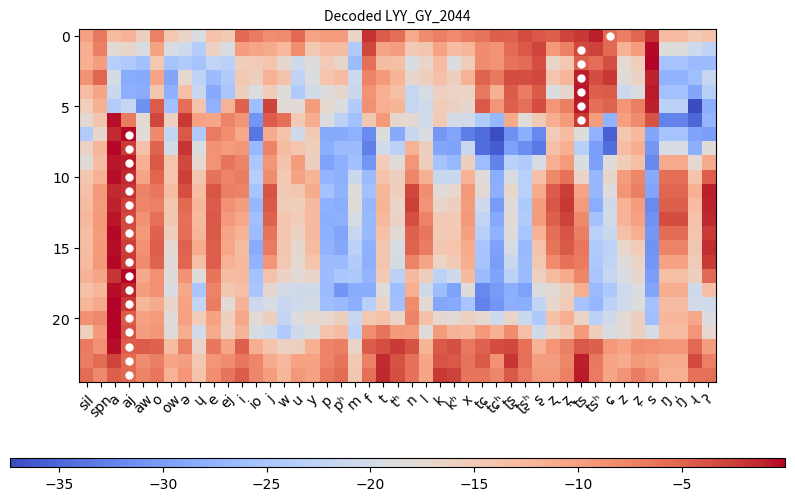

In [14]:
import matplotlib.pyplot as plt
phone_table = agent.phone_table
# directly copy from terminal
utt_ids = list(ali_map.keys())
tgt_utt_id = utt_ids[10]
pmat = lgmmprob_map[tgt_utt_id]
ali_idxs = ali_map[tgt_utt_id]

fig = plt.figure(figsize=(10, 10*(pmat.shape[0]/pmat.shape[1])+1))
plt.imshow(pmat, 
            cmap="coolwarm")

xticks = range(0, len(phone_table), 1)
xticklabels = [phone_table[y] for y in xticks]
plt.plot(ali_idxs-1, np.arange(len(ali_idxs)), color="white", ms=5, marker="o", ls="none")
plt.xticks(xticks, xticklabels, rotation=45) 
plt.colorbar(location="bottom", aspect=80)
plt.title(f"Decoded {tgt_utt_id}", fontsize=20, font="Noto Sans CJK JP")
# fig.savefig(str(fig_dir/f"{utt_x.utt_id}_{word_x.label}.png"))

In [18]:
import json
Path("../../data/fst/xianzai_rzs.json").\
  write_text(json.dumps(common_rzs, indent=2, ensure_ascii=False))

18653

In [25]:
[(x[0], len(x[1])) for x in common_rzs[:10]]

[('ɕ j e n ts aj', 383),
 ('ɕ j e n aj', 125),
 ('ɕ j e aj', 89),
 ('ɕ j e n', 85),
 ('ɕ j aj', 44),
 ('ɕ j e ts aj', 24),
 ('ɕ e n ts aj', 24),
 ('ɕ j n aj', 15),
 ('ɕ j e', 13),
 ('ɕ j n', 11)]

In [38]:
from pathlib import Path
from IPython.display import Audio
wav_dir = Path(f"~/lago/mfa_data/xianzai/s1/").expanduser()
rz_idx = 9
utt_idx = 9
utt_id = common_rzs[rz_idx][1][utt_idx]
print(common_rzs[rz_idx][0], common_rzs[rz_idx][1][utt_idx])
Audio(wav_dir/f"{utt_id}.wav", rate=22050)

ɕ j n GWH_GY_4931


## Exported Artefacts

In [20]:
!sha1sum ../../data/fst/xianzai_phone_loglik.ark
!sha1sum ../../data/fst/xianzai_rzs.json
!sha1sum ../../data/fst/ali.txt

9259328dbacdb2557e03fdfd5b3f12f91d583b5b  ../../data/fst/xianzai_phone_loglik.ark
96fe73ea558faf13d0b5c810d3185aac60c7dc1a  ../../data/fst/xianzai_rzs.json
84a32bcd8741ac867a4a87bbbdfc396fc2500a9e  ../../data/fst/ali.txt
